# 📊 Loan Default Risk Analysis — Exploratory Data Analysis & Baseline Modeling

## 1. Objective

The purpose of this notebook is to perform an **end-to-end exploratory data analysis (EDA)** and develop a **baseline predictive model** to understand the key drivers of **loan default risk**.

The analysis focuses on:
- Understanding borrower, loan, and credit characteristics
- Identifying variables that differentiate default vs non-default behavior
- Establishing a robust, interpretable baseline model to serve as a benchmark for further refinement

---

## 2. Dataset Description

The dataset was obtained from kaggle (Lending Club Loan Data):
https://www.kaggle.com/datasets/saurabh13nov/lending-club-loan-data

The dataset consists of consumer loan records with:
- Loan attributes (amount, term, interest rate, installment)
- Borrower characteristics (income, employment length, home ownership)
- Credit behavior indicators (debt-to-income, revolving utilization, delinquencies)
- Loan outcomes used to derive a binary default indicator

---

## 3. Analytical Approach

The analysis follows a structured workflow:

1. Data Cleaning**

2. Exploratory Data Analysis**

3. Feature Engineering**

4. Feature Selection**

5. Baseline Modeling**
   
---

## 4. Intended Outcome

- Clearly identify the strongest drivers of loan default
- Validate that the dataset contains meaningful predictive signal
- Establish a solid analytical foundation for future modeling enhancements



## Step 1: Data Cleaning

In this first step, we prepared the raw dataset for analysis by improving its quality and consistency. We inspected the data to identify missing values, duplicate records, and obvious input errors, then applied appropriate fixes (e.g., removing duplicates, imputing or excluding missing fields where necessary). We also standardized data types and formats (such as dates and numeric fields), normalized categorical values to avoid inconsistent labels, and checked for outliers or impossible values that could distort results. By the end of this stage, the dataset is more reliable, easier to work with, and ready for downstream exploration, feature engineering, and modeling.


In [1]:
# Load the data
import pandas as pd

df = pd.read_csv("/content/loan.csv", low_memory=False)
print(df.shape)



(887379, 74)


In [2]:
# Initial inspection
# Basic shape
df.shape

# Column types & non-null counts
df.info()

# Quick glance
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Drop columns that are IDs, URLs, or not usable
cols_to_drop = [
    # Identifiers / URLs
    'id', 'member_id', 'url',

    # Free text (usually not useful for EDA)
    'emp_title', 'desc', 'title',

    # Post-loan outcome leakage that cannot help predicting as they are post-approval
    'out_prncp', 'out_prncp_inv',
    'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries',
    'collection_recovery_fee',
    'last_pymnt_amnt',
    'next_pymnt_d',
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])


In [4]:
# Fix data types
# percentages to numeric
df['int_rate'] = (
    df['int_rate']
      .astype(str)                      # works even if already numeric
      .str.replace('%', '', regex=False)
      .str.strip()
)

# Convert to numeric; non-parsable values -> NaN
df['int_rate'] = pd.to_numeric(df['int_rate'], errors='coerce')

df['revol_util'] = (
    df['revol_util']
      .astype(str)
      .str.replace('%', '', regex=False)
      .str.strip()
)

df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')

# Term to numeric months
df['term'] = (
    df['term']
    .str.extract(r'(\d+)')
    .astype(float)
)
# Employment lenght to numeric
emp_length_map = {
    '< 1 year': 0.5,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(emp_length_map)
# Parse dates properly
date_cols = [
    'issue_d',
    'earliest_cr_line',
    'last_pymnt_d',
    'last_credit_pull_d'
]

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%b-%Y', errors='coerce')

# Handle missing values
# Numerical columns, flag important missingness
num_cols = df.select_dtypes(include='number').columns

missing_pct = df[num_cols].isna().mean().sort_values(ascending=False)
missing_pct.head(15)
# Drop columns with extreme missingness (>70%)
high_missing = missing_pct[missing_pct > 0.70].index
df = df.drop(columns=high_missing)
# Categorical columns: standarize + fill "unknown"
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = (
        df[col]
        .str.strip()
        .str.lower()
        .fillna('unknown')
    )
# Normalize categorical values
# Home ownership cleanup
df['home_ownership'] = df['home_ownership'].replace({
    'none': 'rent',
    'any': 'other'
})

# Loan status normalization
df['loan_status'] = df['loan_status'].str.replace(' ', '_')
# Remove data errors, impossible values
# Annual income must be positive
df = df[df['annual_inc'] > 0]

# DTI should be reasonable
df = df[(df['dti'] >= 0) & (df['dti'] <= 100)]

# Revolving utilization
df = df[(df['revol_util'].isna()) | ((df['revol_util'] >= 0) & (df['revol_util'] <= 150))]
# Duplicate check
df.duplicated().sum()

df = df.drop_duplicates()
# Final validation
df.info()
df.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])


<class 'pandas.core.frame.DataFrame'>
Index: 887349 entries, 0 to 887378
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   loan_amnt                   887349 non-null  float64       
 1   funded_amnt                 887349 non-null  float64       
 2   funded_amnt_inv             887349 non-null  float64       
 3   term                        887349 non-null  float64       
 4   int_rate                    887349 non-null  float64       
 5   installment                 887349 non-null  float64       
 6   grade                       887349 non-null  object        
 7   sub_grade                   887349 non-null  object        
 8   emp_length                  842533 non-null  float64       
 9   home_ownership              887349 non-null  object        
 10  annual_inc                  887349 non-null  float64       
 11  verification_status         887349 non-null 

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,issue_d,dti,...,revol_util,total_acc,last_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,887349.000000,887349.000000,887349.000000,887349.000000,887349.000000,887349.000000,842533.000000,8.873490e+05,887349,887349.000000,...,886851.000000,887324.000000,869693,887296,887208.000000,887349.0,887324.000000,8.170770e+05,8.170770e+05,8.170770e+05
mean,14755.267093,14741.879661,14702.478751,43.201117,13.246701,436.716278,6.050609,7.502781e+04,2014-07-10 06:55:33.587123200,18.131629,...,55.064718,25.268120,2015-08-11 08:10:51.440910592,2015-10-26 00:36:46.116560896,0.014380,1.0,0.004991,2.257098e+02,1.394571e+05,3.206879e+04
min,500.000000,500.000000,0.000000,36.000000,5.320000,15.670000,0.500000,1.896000e+03,2007-06-01 00:00:00,0.000000,...,0.000000,1.000000,2007-12-01 00:00:00,2007-05-01 00:00:00,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1%,1800.000000,1800.000000,1600.000000,36.000000,5.320000,60.650000,0.500000,1.900000e+04,2010-01-01 00:00:00,1.980000,...,2.200000,6.000000,2011-11-01 00:00:00,2012-11-01 00:00:00,0.000000,1.0,0.000000,0.000000e+00,3.656760e+03,3.000000e+03
5%,3600.000000,3600.000000,3500.000000,36.000000,6.620000,120.420000,0.500000,2.800000e+04,2012-01-01 00:00:00,5.200000,...,13.900000,9.000000,2013-11-01 00:00:00,2014-10-01 00:00:00,0.000000,1.0,0.000000,0.000000e+00,9.173000e+03,6.000000e+03
50%,13000.000000,13000.000000,13000.000000,36.000000,12.990000,382.550000,6.000000,6.500000e+04,2014-11-01 00:00:00,17.650000,...,56.000000,24.000000,2016-01-01 00:00:00,2016-01-01 00:00:00,0.000000,1.0,0.000000,0.000000e+00,8.055900e+04,2.370000e+04
95%,32000.000000,32000.000000,32000.000000,60.000000,20.990000,906.336000,10.000000,1.500000e+05,2015-11-01 00:00:00,32.720000,...,92.500000,47.000000,2016-01-01 00:00:00,2016-01-01 00:00:00,0.000000,1.0,0.000000,6.350000e+02,4.246522e+05,8.300000e+04
99%,35000.000000,35000.000000,35000.000000,60.000000,24.990000,1184.860000,10.000000,2.500000e+05,2015-12-01 00:00:00,37.480000,...,98.500000,60.000000,2016-01-01 00:00:00,2016-01-01 00:00:00,1.000000,1.0,0.000000,4.606000e+03,6.589942e+05,1.516000e+05
max,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1445.460000,10.000000,9.500000e+06,2015-12-01 00:00:00,90.000000,...,148.000000,169.000000,2016-01-01 00:00:00,2016-01-01 00:00:00,20.000000,1.0,14.000000,9.152545e+06,8.000078e+06,9.999999e+06
std,8435.455358,8429.897229,8442.089439,10.998675,4.381875,244.184377,3.599482,6.469826e+04,NaN,8.306171,...,23.811760,11.840509,NaN,NaN,0.134193,0.0,0.077626,1.031153e+04,1.537454e+05,3.749744e+04


## Step 2: Exploratory Data Analysis (EDA)

In this step, we explored the cleaned dataset to understand its structure, distributions, and underlying patterns. We analyzed summary statistics to assess central tendency and variability, examined feature distributions to detect skewness and outliers, and evaluated relationships between variables using correlations and visualizations. We also compared key variables across relevant segments to uncover trends and potential drivers. This exploratory analysis helps validate assumptions, surface data quality issues that may still exist, and guide feature selection and modeling decisions in later stages.


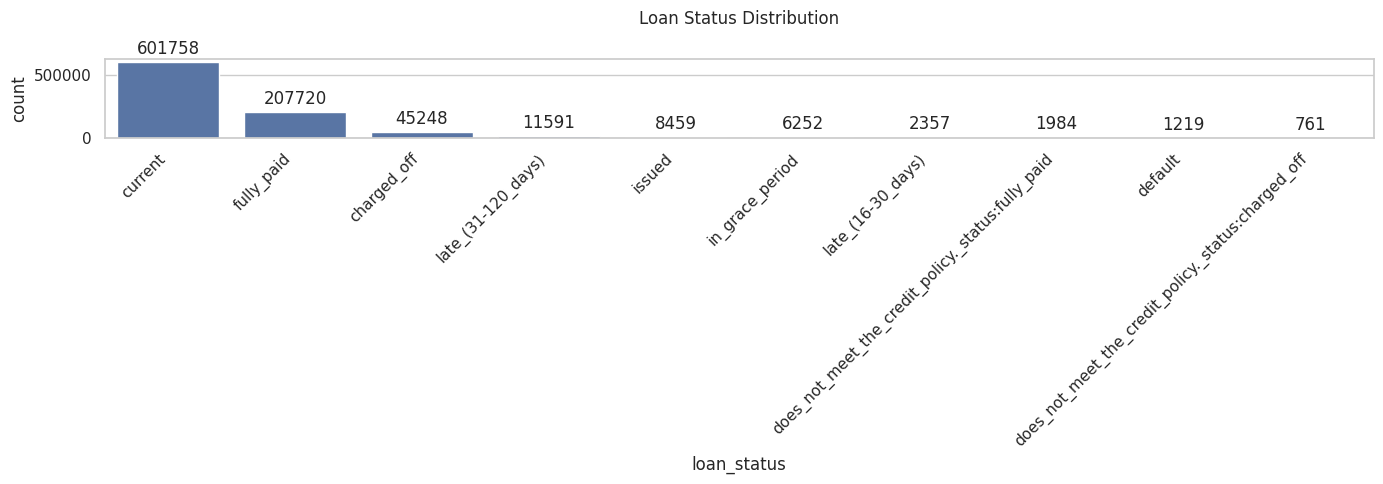

<Figure size 640x480 with 0 Axes>

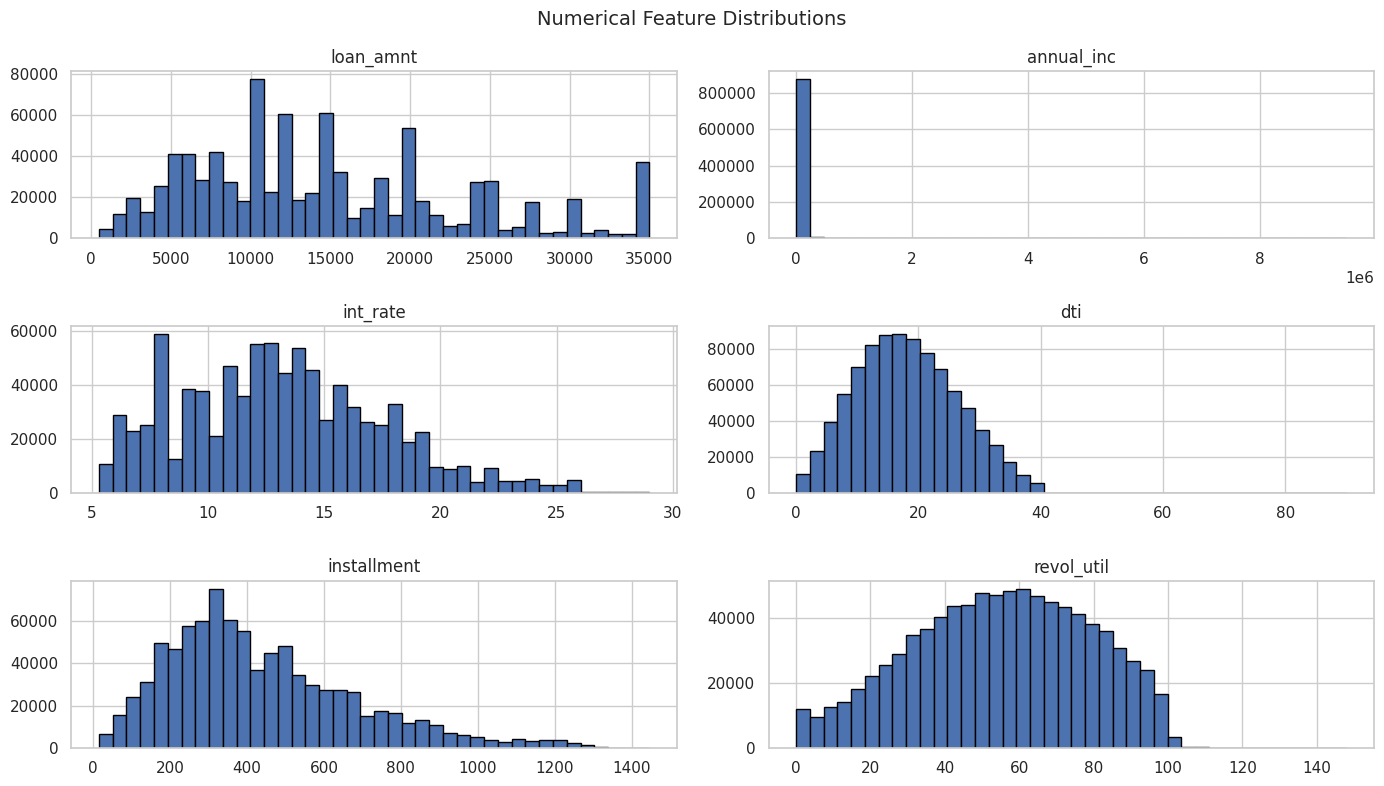

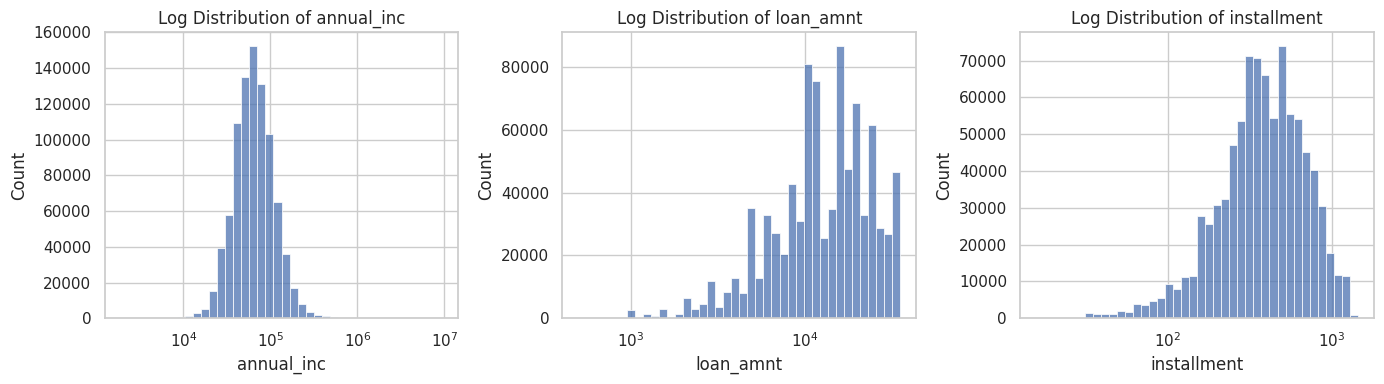

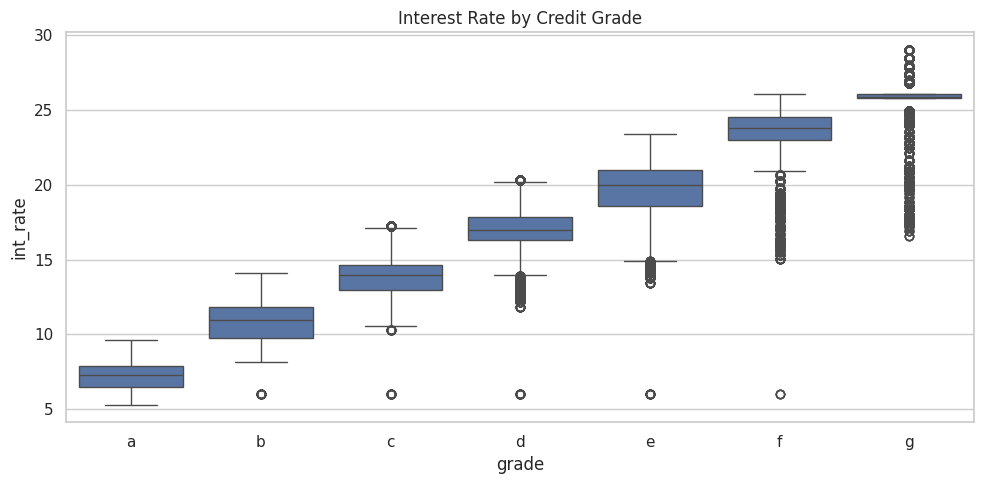

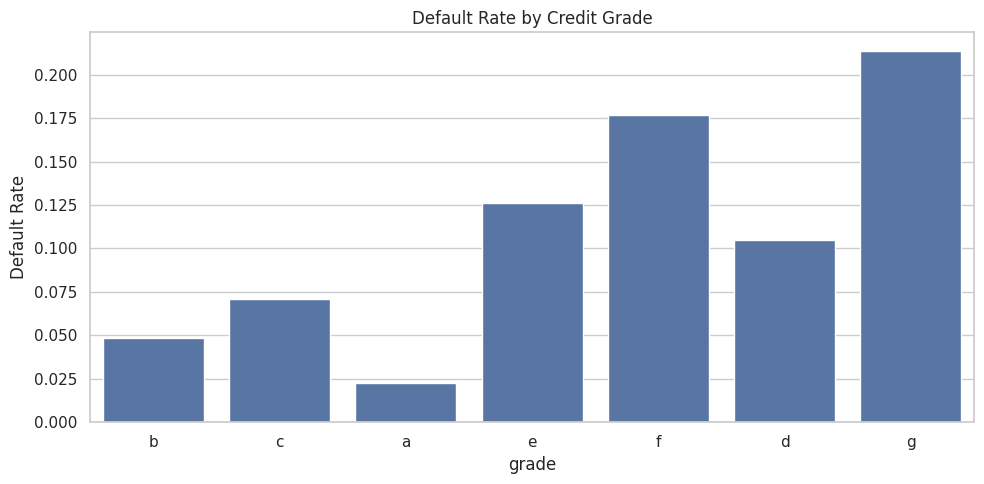

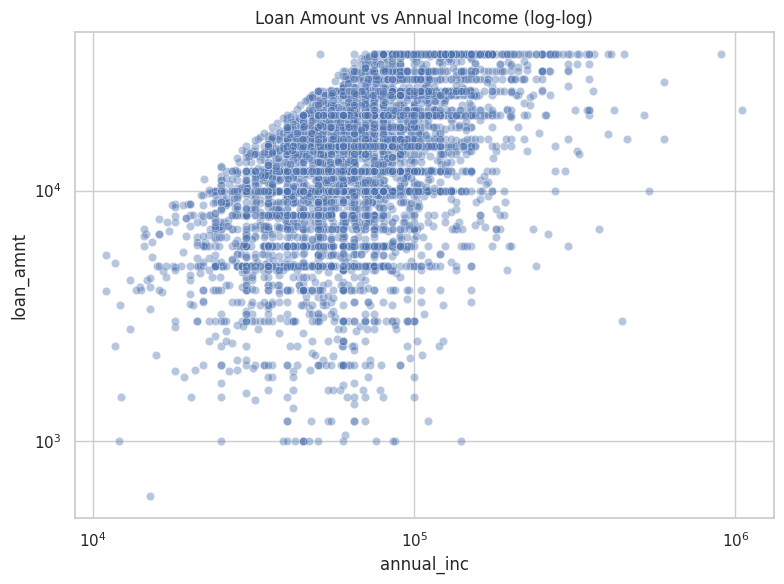

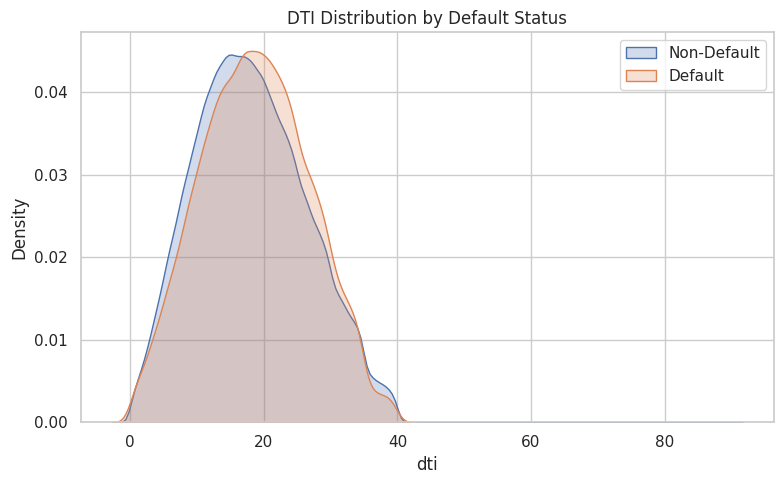

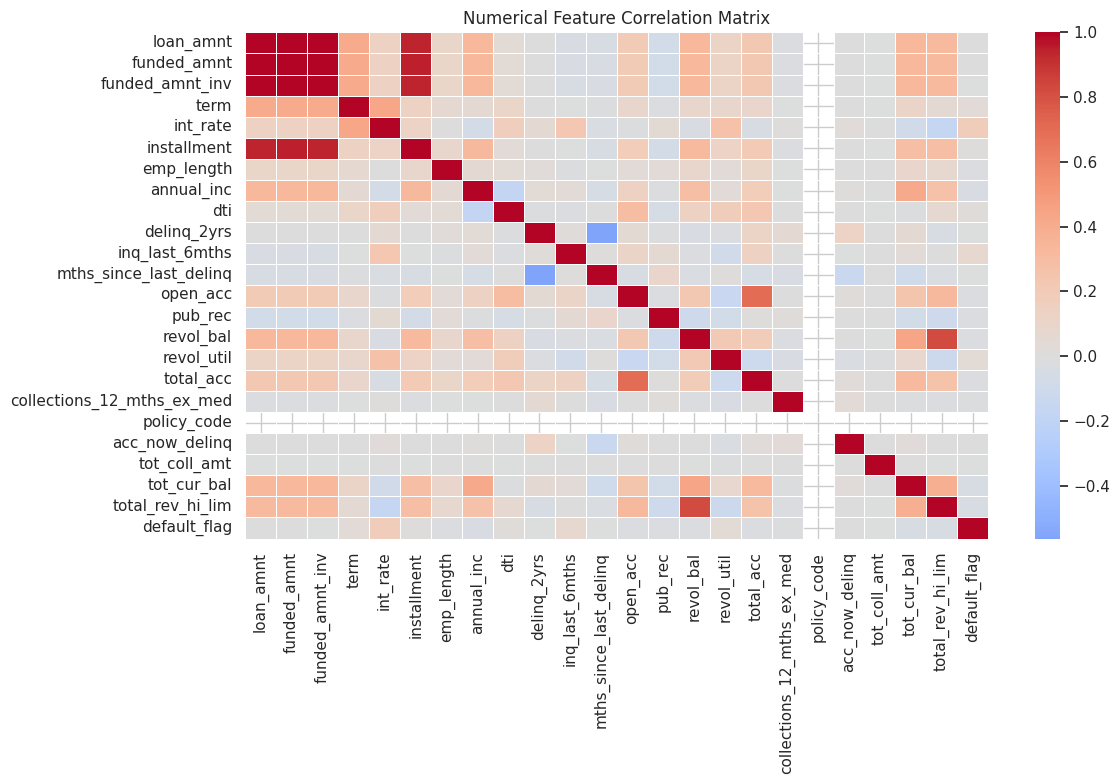

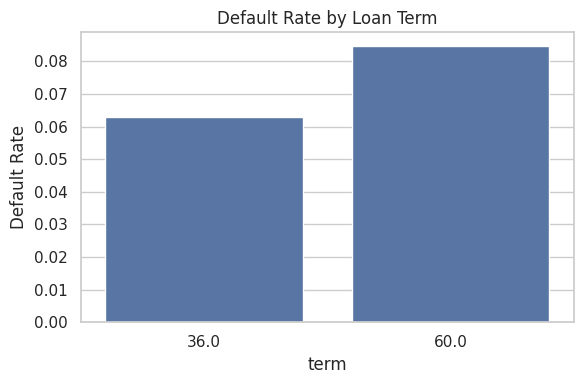

In [7]:
#Exploratory visualization s(EDA)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook")
# Target Variable Overview
counts = df["loan_status"].value_counts()

fig, ax = plt.subplots(figsize=(14,5))
sns.countplot(data=df, x="loan_status", order=counts.index, ax=ax)

ax.set_title("Loan Status Distribution", pad=25)   # <-- pushes title up
ax.bar_label(ax.containers[0], padding=3)          # <-- labels a bit above bars
plt.xticks(rotation=45, ha="right")

fig.subplots_adjust(top=0.80)                      # <-- more room at the top
plt.tight_layout()
plt.show()

# add numbers on bars
ax.bar_label(ax.containers[0], padding=2)

plt.tight_layout()
plt.show()
# Numerical failure distributions (univariate)
num_features = [
    'loan_amnt', 'annual_inc', 'int_rate',
    'dti', 'installment', 'revol_util'
]

df[num_features].hist(
    bins=40,
    figsize=(14, 8),
    edgecolor='black'
)
plt.suptitle('Numerical Feature Distributions', fontsize=14)
plt.tight_layout()
plt.show()
# Log-scaled distributions (skewed variables)
skewed = ['annual_inc', 'loan_amnt', 'installment']

plt.figure(figsize=(14, 4))
for i, col in enumerate(skewed, 1):
    plt.subplot(1, 3, i)
    sns.histplot(
        df[col],
        bins=40,
        log_scale=True
    )
    plt.title(f'Log Distribution of {col}')
plt.tight_layout()
plt.show()
# Interest rate versus credit rate
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x='grade',
    y='int_rate',
    order=sorted(df['grade'].unique())
)
plt.title('Interest Rate by Credit Grade')
plt.tight_layout()
plt.show()
# Default behavior by grade
default_map = {
    'charged_off': 1,
    'default': 1,
    'late_(31-120_days)': 1,
    'late_(16-30_days)': 1,
    'fully_paid': 0,
    'current': 0
}

df['default_flag'] = df['loan_status'].map(default_map)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=df,
    x='grade',
    y='default_flag',
    estimator='mean',
    errorbar=None
)
plt.ylabel('Default Rate')
plt.title('Default Rate by Credit Grade')
plt.tight_layout()
plt.show()
# Loan amount versus income (bivariate)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df.sample(5000, random_state=42),
    x='annual_inc',
    y='loan_amnt',
    alpha=0.4
)
plt.xscale('log')
plt.yscale('log')
plt.title('Loan Amount vs Annual Income (log-log)')
plt.tight_layout()
plt.show()
# DTI vs Default
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df[df['default_flag'] == 0],
    x='dti',
    label='Non-Default',
    fill=True
)
sns.kdeplot(
    data=df[df['default_flag'] == 1],
    x='dti',
    label='Default',
    fill=True
)
plt.title('DTI Distribution by Default Status')
plt.legend()
plt.tight_layout()
plt.show()
# Correlation heatmap(numerical features)
num_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(12, 8))
sns.heatmap(
    df[num_cols].corr(),
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Numerical Feature Correlation Matrix')
plt.tight_layout()
plt.show()
# Term impact on default
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df,
    x='term',
    y='default_flag',
    estimator='mean',
    errorbar=None
)
plt.ylabel('Default Rate')
plt.title('Default Rate by Loan Term')
plt.tight_layout()
plt.show()



## Step 3: Feature Engineering

In this step, we transformed the cleaned and explored data into meaningful input features suitable for modeling. We created derived variables that better capture underlying credit risk drivers, such as affordability and leverage ratios (e.g., loan-to-income or payment-to-income), and encoded categorical variables into numerical representations. We also applied appropriate transformations (such as scaling or log transformations) to address skewed distributions, handled outliers through capping or binning, and ensured feature consistency across the dataset. The goal of this step is to enhance the model’s ability to learn relevant patterns and improve predictive performance while maintaining interpretability and robustness.


In [8]:
# Analysis for feature engineering
# Target binary default
default_map = {
    'charged_off': 1,
    'default': 1,
    'late_(31-120_days)': 1,
    'late_(16-30_days)': 1,
    'fully_paid': 0,
    'current': 0
}

df['default_flag'] = df['loan_status'].map(default_map)

# Drop rows we cannot classify
df = df.dropna(subset=['default_flag'])

# Credit history lenght
df['credit_history_years'] = (
    (df['issue_d'] - df['earliest_cr_line'])
    .dt.days / 365.25
)

# Remove impossible values
df = df[df['credit_history_years'] > 0]

# Affordability and leverage ratios
df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']

df['payment_to_income'] = (
    df['installment'] * 12 / df['annual_inc']
)

df['revol_bal_to_income'] = df['revol_bal'] / df['annual_inc']
# Utilization and delinquency flags
df['high_revol_util'] = (df['revol_util'] > 75).astype(int)

df['prior_delinquency'] = (
    (df['delinq_2yrs'] > 0) |
    (df['pub_rec'] > 0)
).astype(int)
# Term normalization (short vs. long)
df['long_term'] = (df['term'] == 60).astype(int)


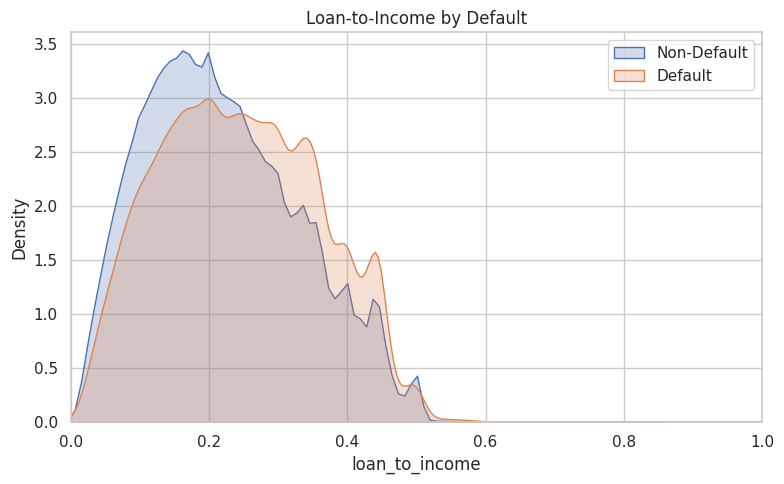

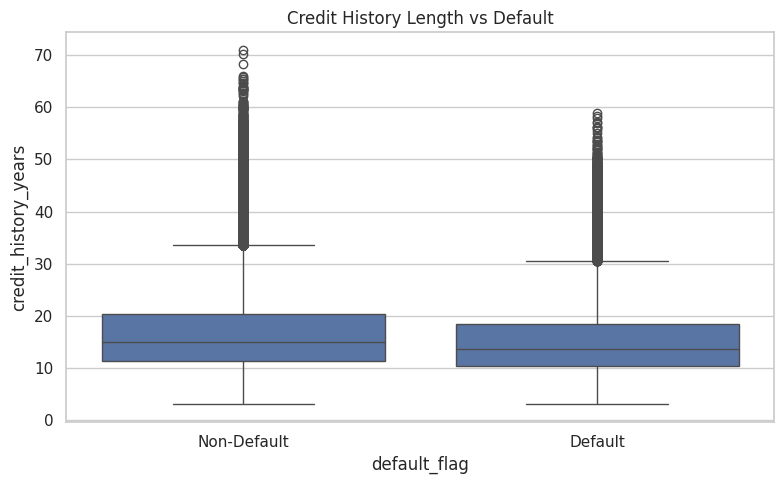

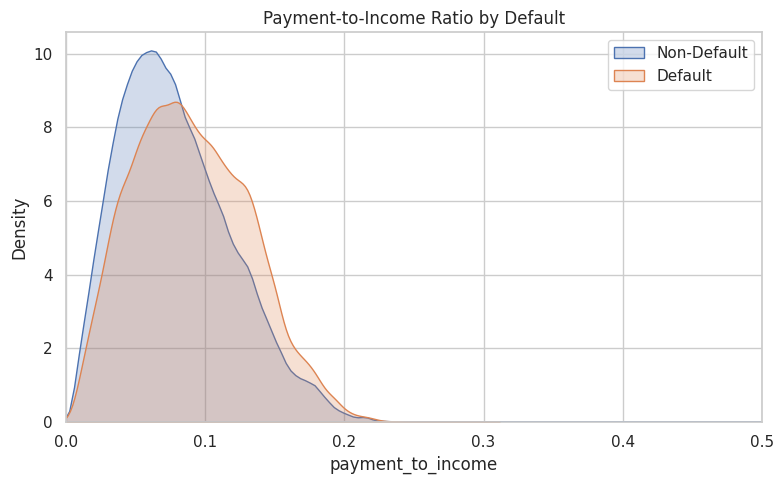

,default_flag
credit_history_years,-0.047320
prior_delinquency,-0.011884
dti,0.020269
high_revol_util,0.037116
long_term,0.039153
revol_util,0.047344
loan_to_income,0.056143
payment_to_income,0.068611
int_rate,0.172538
default_flag,1.000000


In [9]:
# Validation EDA on Engineered Features
# Default rate vs. loan to income
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df[df['default_flag'] == 0],
    x='loan_to_income',
    label='Non-Default',
    fill=True
)
sns.kdeplot(
    data=df[df['default_flag'] == 1],
    x='loan_to_income',
    label='Default',
    fill=True
)
plt.xlim(0, 1)
plt.title('Loan-to-Income by Default')
plt.legend()
plt.tight_layout()
plt.show()
# Credit history lenght vs. default
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='default_flag',
    y='credit_history_years'
)
plt.xticks([0,1], ['Non-Default','Default'])
plt.title('Credit History Length vs Default')
plt.tight_layout()
plt.show()
# Payment burden vs. default
plt.figure(figsize=(8,5))
sns.kdeplot(
    data=df[df['default_flag'] == 0],
    x='payment_to_income',
    label='Non-Default',
    fill=True
)
sns.kdeplot(
    data=df[df['default_flag'] == 1],
    x='payment_to_income',
    label='Default',
    fill=True
)
plt.xlim(0, 0.5)
plt.title('Payment-to-Income Ratio by Default')
plt.legend()
plt.tight_layout()
plt.show()
# Enginnered feature importance (correlation check)
engineered_features = [
    'loan_to_income',
    'payment_to_income',
    'credit_history_years',
    'revol_util',
    'high_revol_util',
    'prior_delinquency',
    'long_term',
    'int_rate',
    'dti'
]

df[engineered_features + ['default_flag']].corr()['default_flag'].sort_values()



## Step 4: Feature Selection

In this step, we identified and retained the most relevant features for predicting credit default while removing redundant, noisy, or low-value variables. We evaluated feature importance using a combination of statistical measures, correlation analysis, and model-based techniques to detect multicollinearity and weak predictors. Features that introduced data leakage, duplicated information (e.g., highly correlated proxies), or were not available at decision time were excluded. This selection process helps reduce model complexity, improve generalization, and enhance interpretability, ensuring that the final feature set captures the key risk drivers without overfitting.


In [13]:
# Feature selection
# Define candidate feature pool(only preloan, risk-relevant features)
candidate_features = [
    # Loan characteristics
    'loan_amnt',
    'term',
    'int_rate',
    'installment',

    # Borrower profile
    'annual_inc',
    'emp_length',
    'home_ownership',
    'verification_status',

    # Credit behavior
    'dti',
    'delinq_2yrs',
    'pub_rec',
    'revol_bal',
    'revol_util',
    'total_acc',
    'open_acc',

    # Engineered features
    'loan_to_income',
    'payment_to_income',
    'credit_history_years',
    'high_revol_util',
    'prior_delinquency',
    'long_term'
]

target = 'default_flag'

# Remove near zero variance features
from sklearn.feature_selection import VarianceThreshold

num_feats = df[candidate_features].select_dtypes(include='number').columns

vt = VarianceThreshold(threshold=0.01)
vt.fit(df[num_feats])

low_variance = num_feats[~vt.get_support()]
low_variance
#
candidate_features = [f for f in candidate_features if f not in low_variance]

# Default rate by feature
def default_rate_by_feature(feature, bins=10):
    tmp = df[[feature, target]].dropna()
    tmp['bin'] = pd.qcut(tmp[feature], bins, duplicates='drop')
    return tmp.groupby('bin')[target].mean()

default_rate_by_feature('loan_to_income')
default_rate_by_feature('credit_history_years')
default_rate_by_feature('payment_to_income')
# Multicolinearity removal
import numpy as np

corr = df[candidate_features].select_dtypes(include='number').corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr = [
    column for column in upper.columns
    if any(upper[column] > 0.75)
]

high_corr

# We keep the more interpretable/risk aligned feature
features_to_drop = [
    'installment',        # redundant with loan_amnt + term
    'payment_to_income',  # redundant with loan_to_income
    'term'                # replaced by long_term
]

candidate_features = [
    f for f in candidate_features if f not in features_to_drop
]
# Fina correlation with target (sanity check)
# Separate numeric features
numeric_features = (
    df[candidate_features]
    .select_dtypes(include='number')
    .columns
    .tolist()
)

final_corr = (
    df[numeric_features + [target]]
    .corr()[target]
    .sort_values(key=abs, ascending=False)
)

final_corr

# Final feature set
final_features = [
    'loan_amnt',
    'int_rate',
    'annual_inc',
    'emp_length',
    'dti',
    'revol_util',
    'total_acc',
    'open_acc',
    'loan_to_income',
    'credit_history_years',
    'high_revol_util',
    'prior_delinquency',
    'long_term'
]


/tmp/ipython-input-981860073.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return tmp.groupby('bin')[target].mean()
/tmp/ipython-input-981860073.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return tmp.groupby('bin')[target].mean()
/tmp/ipython-input-981860073.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return tmp.groupby('bin')[target].mean()


In [14]:
# Evaluation of categorical variables
# Default rate by categorical feature
def default_rate_categorical(col):
    return (
        df.groupby(col)[target]
        .mean()
        .sort_values(ascending=False)
    )

print(default_rate_categorical('home_ownership'))
print(default_rate_categorical('verification_status'))


home_ownership
other       0.183673
rent        0.081063
own         0.065497
mortgage    0.060881
Name: default_flag, dtype: float64
verification_status
verified           0.087645
source verified    0.061541
not verified       0.059371
Name: default_flag, dtype: float64


## Step 5: Baseline Modeling

In this step, we built an initial baseline model to establish a reference level of performance for credit default prediction. Using a simple, well-understood algorithm (such as logistic regression or a basic tree-based model), we trained the model on the selected features with minimal tuning. The baseline allows us to validate the modeling pipeline end to end, assess whether the engineered features carry predictive signal, and quantify performance using standard evaluation metrics. This reference point is critical for comparing more advanced models and ensuring that subsequent improvements are meaningful rather than incidental.


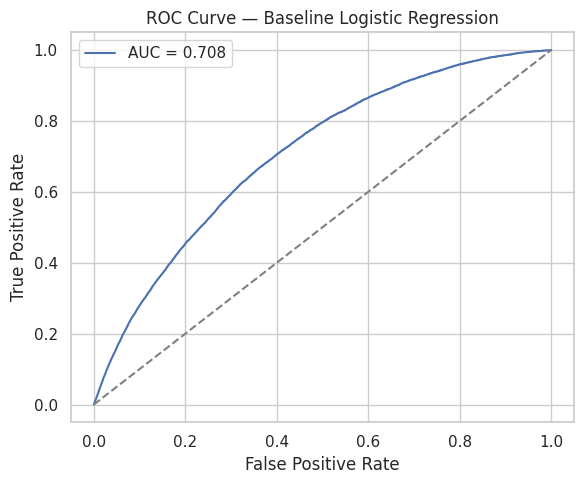

,feature,coefficient,abs_coef
1,num__int_rate,0.741049,0.741049
8,num__loan_to_income,0.174984,0.174984
0,num__loan_amnt,-0.159926,0.159926
12,num__long_term,-0.152566,0.152566
16,cat__verification_status_source verified,-0.111905,0.111905
6,num__total_acc,0.106542,0.106542
17,cat__verification_status_verified,0.103296,0.103296
15,cat__home_ownership_rent,0.101623,0.101623
11,num__prior_delinquency,-0.083036,0.083036
9,num__credit_history_years,-0.077422,0.077422


In [16]:
# Encoding and baseline logistic regression
# Final feature set (numeric vs. categorical)
from sklearn.pipeline import Pipeline
numeric_features = [
    'loan_amnt',
    'int_rate',
    'annual_inc',
    'emp_length',
    'dti',
    'revol_util',
    'total_acc',
    'open_acc',
    'loan_to_income',
    'credit_history_years',
    'high_revol_util',
    'prior_delinquency',
    'long_term'
]

categorical_features = [
    'home_ownership',
    'verification_status'
]

target = 'default_flag'
# train/test split stratified
from sklearn.model_selection import train_test_split

X = df[numeric_features + categorical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#
# Additional preprocessing fixing NANs
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Numeric pipeline
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)
# Categorical pipeline
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)
# Combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Logistic regression model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)
# Full pipeline
from sklearn.pipeline import Pipeline

model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', log_reg)
    ]
)
# Fit the Model
model.fit(X_train, y_train)
# Evaluation
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Baseline Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()
# Coefficient inspection (interpretability payoff)
# Extract feature names
feature_names = (
    model.named_steps['preprocessor']
    .get_feature_names_out()
)

coefficients = model.named_steps['classifier'].coef_[0]

coef_df = (
    pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients
    })
    .assign(abs_coef=lambda x: x['coefficient'].abs())
    .sort_values('abs_coef', ascending=False)
)

coef_df.head(15)


## Summary of Findings — Baseline Credit Default Model

- The baseline logistic regression achieved an **ROC–AUC of 0.708**, indicating **moderate predictive power** and meaningful separation between default and non-default cases.
- Model performance is consistent with expectations for an initial credit risk model and provides a solid **benchmark** for further improvement.

### Key Risk Drivers
- **Higher default risk** is associated with:
  - Higher interest rates
  - Higher loan-to-income ratios
  - Prior delinquencies
- **Lower default risk** is associated with:
  - Higher income
  - Lower DTI
  - Longer employment history
  - Home ownership

### Model Quality and Limitations
- Coefficient signs are economically intuitive, supporting **model interpretability and stability**.
- Logistic regression’s linear assumptions may limit its ability to capture nonlinear risk patterns.
- ROC–AUC alone does not reflect business impact; additional metrics are required.

### Next Steps
- Evaluate more advanced models to capture nonlinear effects.
- Assess precision–recall, lift, and calibration to translate performance into business value.
- Review feature inclusion (e.g., interest rate) based on modeling objectives.

**Conclusion:**  
The baseline model confirms the presence of strong credit risk signal and establishes a reliable foundation for more advanced modeling stages.
